<a href="https://colab.research.google.com/github/superasymmetry/CPSY1291_finalproject/blob/main/CPSY1291_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y jax jaxlib
!pip uninstall -y tensorflow-decision-forests tensorflow-text tf-keras

!pip install tensorflow==2.19.0

!pip install datasets==3.6.0

!pip install captum

!pip install datasets==3.6.0


In [ ]:
import tensorflow as tf
import scipy.fftpack as fp
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import json
import statistics
import random
import math
from captum.attr import Saliency

##Remove frequencies

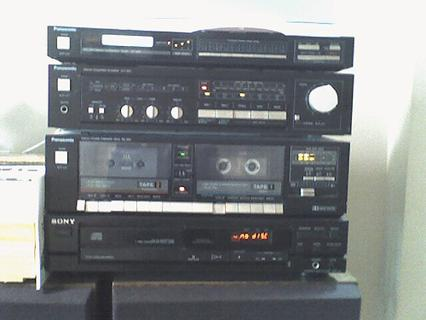

In [ ]:
from datasets import load_dataset

ds = load_dataset("frgfm/imagenette", "320px")

image = ds["train"][1]["image"]
image

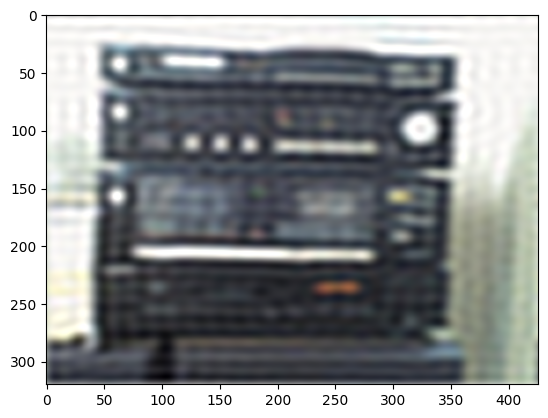

In [ ]:
from tensorflow.python.ops.math_ops import imag_eager_fallback
from scipy import fftpack
import numpy as np
import imageio
from PIL import Image, ImageDraw

image_data = np.array(image)
image_red = image_data[:,:,0]
image_green = image_data[:,:,1]
image_blue = image_data[:,:,2]

def remove_freqs(img_data, threshold):
  image_fft = fftpack.fftshift(fftpack.fft2(np.transpose(img_data, axes=(1,0))))
  x,y = img_data.shape[0], img_data.shape[1]
  #size of circle
  e_x,e_y=50,50
  #create a box
  bbox=((x/2)-(e_x/2),(y/2)-(e_y/2),(x/2)+(e_x/2),(y/2)+(e_y/2))
  low_pass=Image.new("L",(img_data.shape[0],img_data.shape[1]),color=0)
  draw1=ImageDraw.Draw(low_pass)
  draw1.ellipse(bbox, fill=1)

  low_pass_np=np.array(low_pass)

  #multiply both the images
  filtered=np.multiply(image_fft,low_pass_np)

  #inverse fft
  ifft2 = np.real(fftpack.ifft2(fftpack.ifftshift(filtered)))
  ifft2 = np.maximum(0, np.minimum(ifft2, 255))
  return np.transpose(ifft2, axes=(1,0))

# print(image_data.shape)

red_inverse = remove_freqs(image_red, 0.01)
green_inverse = remove_freqs(image_green, 0.01)
blue_inverse = remove_freqs(image_blue, 0.01)
inverse = np.stack([red_inverse, green_inverse, blue_inverse], axis=2)
plt.imshow(inverse)
img_norm = (inverse - inverse.min()) / (inverse.max() - inverse.min())
plt.imshow(img_norm)

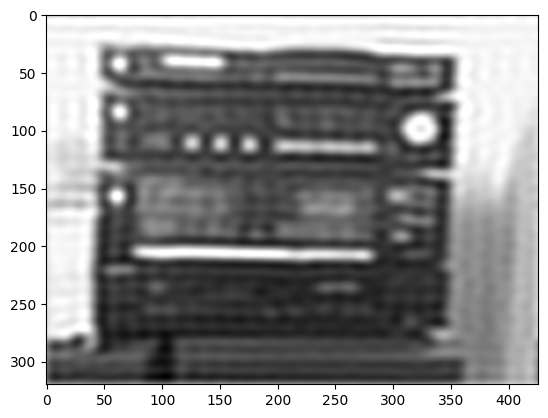

In [ ]:
image_gray = np.mean(np.array(image).astype(float), axis=2)
gray_inverse = remove_freqs(image_gray, 0.01)

plt.imshow(gray_inverse, cmap='gray')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Test harmonized model

In [ ]:
!wget https://storage.googleapis.com/serrelab/prj_harmonization/models/vgg16_harmonized.h5 -O vgg16_harmonized.h5

model = tf.keras.models.load_model("vgg16_harmonized.h5")

--2025-12-13 20:10:16--  https://storage.googleapis.com/serrelab/prj_harmonization/models/vgg16_harmonized.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.207, 64.233.180.207, 142.251.16.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1106996760 (1.0G) [application/octet-stream]
Saving to: ‘vgg16_harmonized.h5’

vgg16_harmonized.h5 100%[===================>]   1.03G  21.4MB/s    in 21s     

2025-12-13 20:10:37 (50.6 MB/s) - ‘vgg16_harmonized.h5’ saved [1106996760/1106996760]



In [ ]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-dog-royalty-free-image-505534037-1565105327.jpg -O sample_image.jpg

!gdown 13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj

--2025-12-13 20:10:57--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-dog-royalty-free-image-505534037-1565105327.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541440 (529K) [image/jpeg]
Saving to: ‘sample_image.jpg’

sample_image.jpg    100%[===================>] 528.75K  --.-KB/s    in 0.007s  

2025-12-13 20:10:57 (77.1 MB/s) - ‘sample_image.jpg’ saved [541440/541440]

Downloading...
From: https://drive.google.com/uc?id=13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj
To: /content/imagenet_classes.json
100% 32.6k/32.6k [00:00<00:00, 59.9MB/s]


In [ ]:
#make sure running on gpu
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

#import VGG19 model
vgg16 = models.vgg16(weights="IMAGENET1K_V1").to(device)
vgg16.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#assess VGG16 on Imagenette
labels_imagenette = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
imagenette_indices = [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]

preprocess_im = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

#function specific for unharmonized model
def model_pred(outputs, class_labels):

  outputs_imagenette_specific = outputs[0, imagenette_indices]
  compute = F.softmax(outputs_imagenette_specific, dim=0)
  probability, predicted_class = torch.max(compute, dim=0)
  return str(labels_imagenette[predicted_class.item()])

def load_preprocess(img):
  image_tensor = preprocess_im(img)
  image_tensor.unsqueeze_(0)
  return image_tensor

#function for decoding for harmonized model
def decode_preds(outputs, class_names):
  # Assuming outputs is the tensor of model outputs
  outputs_imagenette_specific = outputs[0, imagenette_indices]
  softmax_outputs = np.exp(outputs_imagenette_specific) / np.sum(np.exp(outputs), axis=1, keepdims=True)
  softmax_outputs = torch.from_numpy(softmax_outputs)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[idx] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()
  return predicted_class_labels


In [ ]:
# clean the dataset to remove greyscale images
from typing import List
from datasets import Dataset, DatasetDict

def remove_greyscale(dataset, set_names: List[str]):
  new_ds = DatasetDict()
  # initialize the lists for each set
  for i in range(len(set_names)):
    set_name = set_names[i]
    new_ds[set_name] = []
    for j in range(len(ds[set_name])):
      data = ds[set_name][j]
      image = data["image"]
      image_data = np.array(image)
      if len(image_data.shape) == 3:
        new_ds[set_name].append(data)
    Dataset.from_list(new_ds[set_name])
  return new_ds

new_ds = remove_greyscale(ds, ["validation"])


In [ ]:
#This shows how many grayscale images are filtered out
print('Number of grayscale images filtered out: ' + str(len(ds["validation"]) - len(new_ds["validation"])))


Number of grayscale images filtered out: 69


In [ ]:
#functions for accuracy

def unharmonized_acc(dataset, model, num_batches, batchsize):
  correct = 0
  all_acc = []

  for j in range(num_batches):
    correct = 0
    for m in range(batchsize):
      i = random.randint(1,len(dataset)-1)
      ground_truth = labels_imagenette[dataset[i]["label"]]
      im = load_preprocess(dataset[i]["image"]).to(device)
      with torch.no_grad():
        output= model(im)
      model_pred(output, labels_imagenette)
      predicted_label = model_pred(output, labels_imagenette)

      if predicted_label == ground_truth:
        correct += 1

    accuracy = correct/batchsize

    final_acc = accuracy * 100
    all_acc.append(accuracy)
    print('Accuracy Batch ' + str(j + 1) + ': '+ str(final_acc))
  if num_batches > 1:
    print( 'Batch Variance: ' + str(statistics.variance(all_acc)))
    print( 'Standard Deviation: ' + str(math.sqrt(statistics.variance(all_acc))))
    print('Average Accuracy: ' + str((sum(all_acc)/num_batches)*100))
  return all_acc

def harmonized_acc(dataset, model, num_batches, batchsize):
  correct = 0
  all_acc = []

  for j in range(num_batches):
    correct = 0
    for m in range(batchsize):
      i = random.randint(1,len(dataset)-1)
      ground_truth = labels_imagenette[dataset[i]["label"]]
      img_preprocessed = preprocess_im(dataset[i]["image"]).permute(1, 2, 0).unsqueeze(0)
      out = model.predict(img_preprocessed)
      predicted_labels = decode_preds(out,labels_imagenette)
      print(predicted_labels)

      if predicted_labels[0] == ground_truth:
        correct += 1

    accuracy = correct/batchsize

    final_acc = accuracy * 100
    all_acc.append(accuracy)

  for l in range(len(all_acc)):
    print('Accuracy Batch ' + str(l + 1) + ': '+ str(all_acc[l]))

  print( 'Batch Variance: ' + str(statistics.variance(all_acc)))
  print( 'Standard Deviation: ' + str(math.sqrt(statistics.variance(all_acc))))
  print('Average Accuracy: ' + str((sum(all_acc)/5)*100))







In [ ]:
harmonized_acc(new_ds["validation"], model, 5, 10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
['chain saw']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
['cassette player']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
['English springer']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
['parachute']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
['English springer']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
['gas pump']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
['garbage truck']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
['gas pump']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
['English springer']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
['garbage truck']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
['parachute']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
['chain saw']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
['garbage truck']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
['garbage truck']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
['cassette player']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
['parachute']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
['English springer']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
['golf

In [ ]:
unharmonized_acc(new_ds["validation"], vgg16, 5, 10)

Accuracy Batch 1: 100.0
Accuracy Batch 2: 90.0
Accuracy Batch 3: 100.0
Accuracy Batch 4: 100.0
Accuracy Batch 5: 100.0
Batch Variance: 0.001999999999999999
Standard Deviation: 0.04472135954999579
Average Accuracy: 98.00000000000001


[1.0, 0.9, 1.0, 1.0, 1.0]

### Create manipulated Dataset

In [ ]:
from PIL import Image
import random
def createManipulatedDataset(ds, set_names, batch_size, threshold):
  new_ds = DatasetDict()
  # initialize the lists for each set
  for i in range(len(set_names)):
    set_name = set_names[i]
    new_ds[set_name] = []
    random_sample = random.sample(range(len(ds[set_name])), batch_size)
    for j in range(batch_size):
      data = ds[set_name][random_sample[j]]
      image = data["image"]
      label = data["label"]
      image_data = np.array(image)
      image_red = image_data[:,:,0]
      image_green = image_data[:,:,1]
      image_blue = image_data[:,:,2]
      red_inverse = remove_freqs(image_red, threshold)
      green_inverse = remove_freqs(image_green, threshold)
      blue_inverse = remove_freqs(image_blue, threshold)
      inverse = np.stack([red_inverse, green_inverse, blue_inverse], axis=2)

      img_norm = (inverse - inverse.min()) / (inverse.max() - inverse.min())

      img_uint8 = (img_norm * 255).astype(np.uint8)

      pil_image = Image.fromarray(img_uint8)
      new_ds[set_name].append({
          "image": pil_image,
          "label": label
      })
    Dataset.from_list(new_ds[set_name])
  return new_ds





In [ ]:
manipulated_ds = createManipulatedDataset(new_ds, ["validation"], 200, 0.45)


In [ ]:
vgg16.eval()

correct = 0

for i in range(100):
  ground_truth = labels_imagenette[manipulated_ds["validation"][i]["label"]]
  im = load_preprocess(manipulated_ds["validation"][i]["image"]).to(device)
  with torch.no_grad():
    output= vgg16(im)
  model_pred(output, labels_imagenette)
  predicted_label = model_pred(output, labels_imagenette)
  print(predicted_label)
  if predicted_label == ground_truth:
    correct += 1

accuracy = correct/100

final_acc = accuracy * 100
print(final_acc)

tench
cassette player
cassette player
chain saw
garbage truck
chain saw
French horn
French horn
cassette player
garbage truck
golf ball
gas pump
golf ball
tench
golf ball
chain saw
English springer
church
garbage truck
garbage truck
parachute
English springer
golf ball
parachute
church
English springer
chain saw
cassette player
parachute
tench
parachute
garbage truck
garbage truck
cassette player
French horn
French horn
gas pump
parachute
English springer
garbage truck
church
English springer
church
tench
English springer
golf ball
parachute
gas pump
tench
church
garbage truck
gas pump
parachute
cassette player
parachute
tench
parachute
gas pump
garbage truck
gas pump
parachute
English springer
church
chain saw
tench
golf ball
chain saw
tench
cassette player
parachute
church
English springer
parachute
church
English springer
church
gas pump
cassette player
gas pump
English springer
golf ball
English springer
chain saw
gas pump
tench
garbage truck
tench
golf ball
parachute
garbage truck

In [ ]:
!git clone https://github.com/bethgelab/model-vs-human.git
%cd model-vs-human
!pip install -e .

Cloning into 'model-vs-human'...
remote: Enumerating objects: 855, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 855 (delta 182), reused 147 (delta 146), pack-reused 605 (from 1)
Receiving objects: 100% (855/855), 26.90 MiB | 24.90 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/model-vs-human
Obtaining file:///content/model-vs-human
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP to /tmp/pip-install-jyy5jiyl/clip_6fec0687bdcd495189d5be394710ddb6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP /tmp/pip-install-jyy5jiyl/clip_6fec0687bdcd495189d5be394710ddb6
  Resolved https://github.com/openai/CLIP to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# get stylized dataset
!git clone https://github.com/rgeirhos/texture-vs-shape.git

Cloning into 'texture-vs-shape'...
remote: Enumerating objects: 2375, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 2375 (delta 31), reused 154 (delta 28), pack-reused 2210 (from 1)
Receiving objects: 100% (2375/2375), 148.67 MiB | 40.25 MiB/s, done.
Resolving deltas: 100% (257/257), done.


In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

root = "/content/texture-vs-shape/stimuli/style-transfer-preprocessed-512"

def get_rand_img_styletransfer(root=root):
  # random object class folder
  class_folder = random.choice(os.listdir(root))
  class_path = os.path.join(root, class_folder)
  while not os.path.isdir(class_path):
      class_folder = random.choice(os.listdir(root))
      class_path = os.path.join(root, class_folder)

  # random image file from the chosen class folder
  images = [f for f in os.listdir(class_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
  image_file = random.choice(images)
  image_path = os.path.join(class_path, image_file)
  img = Image.open(image_path)
  label = class_folder
  return {"image": img, "label": label}

  print("class: ", class_folder)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

In [ ]:
import os
import random
from PIL import Image

root = "/content/texture-vs-shape/stimuli/style-transfer-preprocessed-512"

def createStylizedDataset(root, num_samples=20):
    dataset = []
    class_folders = [f for f in os.listdir(root) if os.path.isdir(os.path.join(root, f))]

    for _ in range(num_samples):
        sample = get_rand_img_styletransfer(root)
        dataset.append(sample)

    return dataset

dataset_dict = createStylizedDataset(root, num_samples=20)
print(dataset_dict)

[{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0ED160>, 'label': 'truck'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0ED6D0>, 'label': 'bird'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0ED730>, 'label': 'bird'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0ED5B0>, 'label': 'bear'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0EDDC0>, 'label': 'car'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0ECDD0>, 'label': 'bottle'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0EDBB0>, 'label': 'truck'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0EDAC0>, 'label': 'cat'}, {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CDACD0EDEE0>, 'label': 'dog'}, {'image': <PIL.Pn

## Plotting Accuracy based on Batch Size

Accuracy Batch 1: 100.0
Accuracy Batch 1: 100.0
Accuracy Batch 1: 100.0
Accuracy Batch 1: 100.0
Accuracy Batch 1: 99.0
Accuracy Batch 1: 100.0


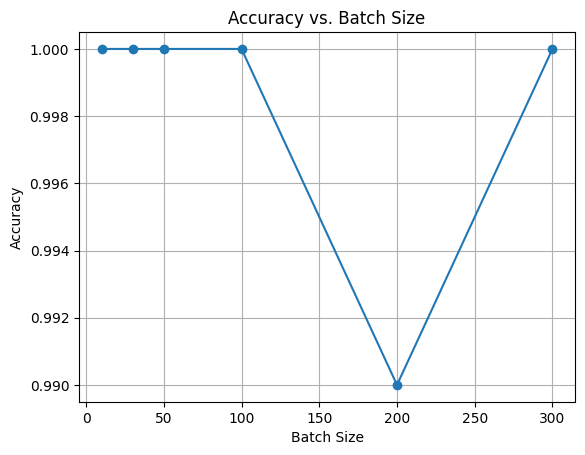

In [ ]:
def plot_accuracy_unharmonized(dataset, model, num_batches, batch_sizes):
  accuracy_unharmonized = []
  for batch_size in batch_sizes:
    final_acc = unharmonized_acc(dataset, model, num_batches=num_batches, batchsize=batch_size)
    accuracy_unharmonized.append(final_acc[0])
  plt.plot(batch_sizes, accuracy_unharmonized, marker='o')
  plt.xlabel('Batch Size')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs. Batch Size (unharmonized)')
  plt.grid(True)
  plt.show()

plot_accuracy_unharmonized(new_ds["validation"], vgg16, 1, [10,30,50,100,200,300])


In [ ]:
def plot_accuracy_harmonized(dataset, model, num_batches, batch_sizes):
  accuracy_harmonized = []
  for batch_size in batch_sizes:
    final_acc = harmonized_acc(dataset, model, num_batches=num_batches, batchsize=batch_size)
    accuracy_harmonized.append(final_acc[0])
  plt.plot(batch_sizes, accuracy_harmonized, marker='o')
  plt.xlabel('Batch Size')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs. Batch Size (harmonized)')
  plt.grid(True)
  plt.show()

plot_accuracy_harmonized(new_ds["validation"], vgg16, 1, [10,30,50,100,200,300])

In [ ]:
print( 'Batch Variance: ' + str(statistics.variance([100,100,100,99,100])))

Batch Variance: 0.2


## Plotting Accuracy Across Batches

Accuracy Batch 1: 99.0
Accuracy Batch 2: 99.0
Accuracy Batch 3: 100.0
Accuracy Batch 4: 100.0
Accuracy Batch 5: 99.0
Batch Variance: 3.0000000000000055e-05
Standard Deviation: 0.0054772255750516665
Average Accuracy: 99.4


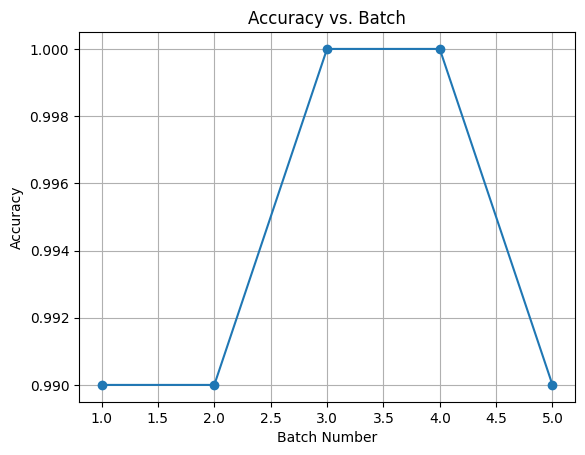

In [ ]:
def plot_accuracy_across_batches_unharmonized(dataset, model, num_batches, batch_size):
  final_accs = unharmonized_acc(dataset, model, num_batches=num_batches, batchsize=batch_size)

  plt.plot(range(1, num_batches + 1), final_accs, marker='o')
  plt.xlabel('Batch Number')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs. Batch')
  plt.grid(True)
  plt.show()

plot_accuracy_across_batches_unharmonized(new_ds["validation"], vgg16, 5, 100)



## Plot Accuracy based on different frequency removals

In [ ]:
vgg16.eval()

threshs = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
res = {}

for thresh in threshs:
  manipulated_ds = createManipulatedDataset(new_ds, ["validation"], 100, thresh)
  correct = 0
  for i in range(100):
    ground_truth = labels_imagenette[manipulated_ds["validation"][i]["label"]]
    im = load_preprocess(manipulated_ds["validation"][i]["image"]).to(device)
    with torch.no_grad():
      output= vgg16(im)
    model_pred(output, labels_imagenette)
    predicted_label = model_pred(output, labels_imagenette)
    print(predicted_label)
    if predicted_label == ground_truth:
      correct += 1

  accuracy = correct/100

  final_acc = accuracy * 100
  print(final_acc)

  res[thresh] = final_acc

In [ ]:
freq_axis = []
acc_axis = []

for k, v in res.items():
  freq_axis.append(k)
  acc_axis.append(v)

plt.plot(freq_axis, acc_axis)
plt.xscale('log')
plt.show()

## Saliency Maps

In [ ]:
from tensorflow.keras.applications import VGG16
vgg16 =  VGG16(weights='imagenet')

In [ ]:
#function for generating saliency maps
def saliency_mapping(model, data_set, image_index):
  #data_set in form new_ds["validation"]
  #referenced keisen.github.io for saliency technique


  img_preprocessed = preprocess_im(data_set[image_index]["image"]).permute(1, 2, 0).unsqueeze(0)


  from tf_keras_vis.utils.scores import CategoricalScore

  # imagenet index of iamgenette
  score = CategoricalScore([data_set[image_index]["label"]])


  from tf_keras_vis.saliency import Saliency

  # from tf_keras_vis.utils import normalize

  # Create Saliency object.
  saliency2 = Saliency(model,clone=True)

  # Generate saliency map
  saliency_map = saliency2(score, img_preprocessed)


  # Render
  plt.figure(figsize=(6,6))
  plt.imshow(saliency_map[0], cmap='jet')
  plt.axis('off')
  plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_572
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


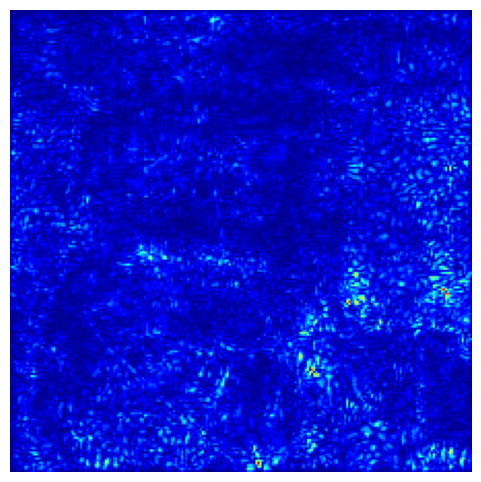

In [ ]:

#referenced keisen.github.io for saliency technique


img_preprocessed = preprocess_im(new_ds["validation"][75]["image"]).permute(1, 2, 0).unsqueeze(0)


from tf_keras_vis.utils.scores import CategoricalScore

# imagenet index of iamgenette
score = CategoricalScore([new_ds["validation"][75]["label"]])


from tf_keras_vis.saliency import Saliency

# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency2 = Saliency(vgg16,clone=True)

# Generate saliency map
saliency_map = saliency2(score, img_preprocessed)




# Render
plt.figure(figsize=(6,6))
plt.imshow(saliency_map[0], cmap='jet')
plt.axis('off')
plt.show()


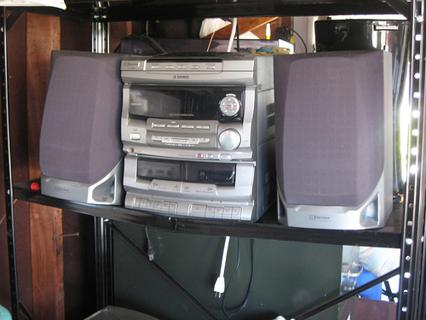

In [ ]:
new_ds["validation"][75]["image"]

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_572
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


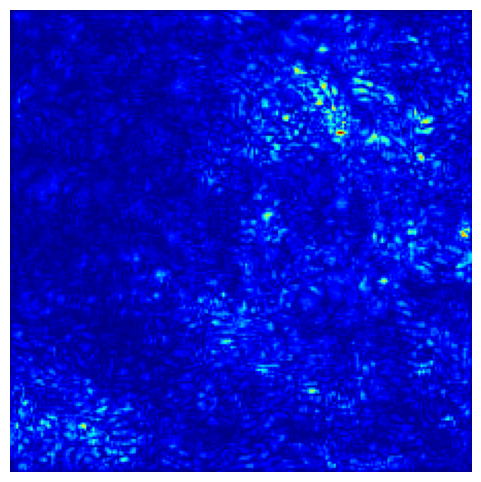

In [ ]:

#referenced keisen.github.io for saliency technique


img_preprocessed = preprocess_im(manipulated_ds["validation"][75]["image"]).permute(1, 2, 0).unsqueeze(0)


from tf_keras_vis.utils.scores import CategoricalScore

# imagenet index of iamgenette
score = CategoricalScore([manipulated_ds["validation"][75]["label"]])


from tf_keras_vis.saliency import Saliency

# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency2 = Saliency(vgg16,clone=True)

# Generate saliency map
saliency_map = saliency2(score, img_preprocessed)




# Render
plt.figure(figsize=(6,6))
plt.imshow(saliency_map[0], cmap='jet')
plt.axis('off')
plt.show()